<a href="https://colab.research.google.com/github/Bhavanalagadapati/CustomerChurn/blob/main/customerchurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2270940020.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TotalCharges"].fillna(data["TotalCharges"].median(), inplace=True)


Epoch 1/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7419 - loss: 0.5198 - val_accuracy: 0.8048 - val_loss: 0.4272
Epoch 2/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7883 - loss: 0.4590 - val_accuracy: 0.7956 - val_loss: 0.4362
Epoch 3/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7732 - loss: 0.4694 - val_accuracy: 0.8006 - val_loss: 0.4293
Epoch 4/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7919 - loss: 0.4493 - val_accuracy: 0.8070 - val_loss: 0.4219
Epoch 5/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7832 - loss: 0.4509 - val_accuracy: 0.8020 - val_loss: 0.4169
Epoch 6/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7877 - loss: 0.4425 - val_accuracy: 0.8070 - val_loss: 0.4173
Epoch 7/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7994 - loss: 0.4301 - val_accuracy: 0.8070 - val_loss: 0.4182
Epoch 8/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7921 - loss: 0.4431 - val_acc

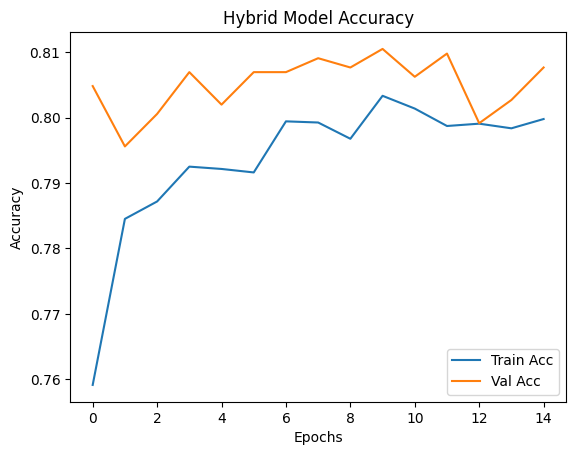

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate

# ---------------------------
# 1. Load & clean data
# ---------------------------
data = pd.read_csv("/content/sample_data/archive (7).zip")
data.drop("customerID", axis=1, inplace=True)

data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"].fillna(data["TotalCharges"].median(), inplace=True)

# Encode categorical columns
for col in data.columns:
    if data[col].dtype == "object":
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

# ---------------------------
# 2. Prepare labels & features
# ---------------------------
y = data["Churn"].values
X = data.drop("Churn", axis=1)

# Select sequence and static feature sets
seq_features = ["MonthlyCharges", "TotalCharges", "Contract"]
static_features = [c for c in X.columns if c not in seq_features + ["tenure"]]

# ---------------------------
# 3. Build pseudo sequences
# ---------------------------
max_len = int(data["tenure"].max())  # 72 months

sequences = []
for _, row in data.iterrows():
    tenure = int(row["tenure"])
    step = [row[f] for f in seq_features]
    seq = [step] * tenure + [[0, 0, 0]] * (max_len - tenure)
    sequences.append(seq)
X_seq = np.array(sequences)  # (n, 72, 3)

# Static (tabular) features
X_static = X[static_features].values

# Scale static features
scaler = StandardScaler()
X_static = scaler.fit_transform(X_static)

# ---------------------------
# 4. Split train/test
# ---------------------------
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.2, random_state=42
)

# ---------------------------
# 5. Build hybrid model
# ---------------------------

# LSTM branch
seq_input = Input(shape=(max_len, len(seq_features)))
x = LSTM(64, return_sequences=False)(seq_input)
x = Dropout(0.3)(x)

# Dense branch (static features)
static_input = Input(shape=(X_static.shape[1],))
y_dense = Dense(64, activation="relu")(static_input)
y_dense = Dropout(0.3)(y_dense)

# Merge both branches
merged = concatenate([x, y_dense])
z = Dense(64, activation="relu")(merged)
z = Dropout(0.3)(z)
output = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# ---------------------------
# 6. Train
# ---------------------------
history = model.fit(
    [X_seq_train, X_static_train],
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=([X_seq_test, X_static_test], y_test),
    verbose=1,
)

# ---------------------------
# 7. Evaluate
# ---------------------------
test_loss, test_acc = model.evaluate([X_seq_test, X_static_test], y_test, verbose=0)
overall_loss, overall_acc = model.evaluate([X_seq, X_static], y, verbose=0)

print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Overall Accuracy: {overall_acc*100:.2f}%")

# ---------------------------
# 8. Plot accuracy
# ---------------------------
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Hybrid Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
